# DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

## Generator

In [2]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [3]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

## Datasets

In [4]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOG9KTQ/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOG9KTQ/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Model, Optimizers

In [5]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [6]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [7]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

epoch: 1, d_loss: 0.9220387935638428, g_loss: 1.0599682331085205


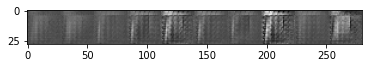

epoch: 2, d_loss: 1.0632109642028809, g_loss: 0.9410364031791687
epoch: 3, d_loss: 1.0493534803390503, g_loss: 0.9639555811882019
epoch: 4, d_loss: 1.032765507698059, g_loss: 0.989607036113739
epoch: 5, d_loss: 1.030832290649414, g_loss: 1.0032116174697876
epoch: 6, d_loss: 1.0298893451690674, g_loss: 1.0145670175552368
epoch: 7, d_loss: 1.0453007221221924, g_loss: 1.012695074081421
epoch: 8, d_loss: 1.065247893333435, g_loss: 1.000380277633667
epoch: 9, d_loss: 1.07758629322052, g_loss: 0.9969724416732788
epoch: 10, d_loss: 1.0809451341629028, g_loss: 0.995177686214447
epoch: 11, d_loss: 1.0759676694869995, g_loss: 1.002231240272522


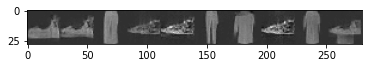

epoch: 12, d_loss: 1.0793070793151855, g_loss: 1.0042871236801147
epoch: 13, d_loss: 1.094420313835144, g_loss: 0.9950922727584839
epoch: 14, d_loss: 1.0987205505371094, g_loss: 0.9954660534858704
epoch: 15, d_loss: 1.0846953392028809, g_loss: 1.0117236375808716
epoch: 16, d_loss: 1.090080976486206, g_loss: 1.0068823099136353
epoch: 17, d_loss: 1.0851491689682007, g_loss: 1.0171295404434204
epoch: 18, d_loss: 1.0947362184524536, g_loss: 1.0116106271743774
epoch: 19, d_loss: 1.0822850465774536, g_loss: 1.022681474685669
epoch: 20, d_loss: 1.0805245637893677, g_loss: 1.0269514322280884
epoch: 21, d_loss: 1.0905818939208984, g_loss: 1.022796630859375


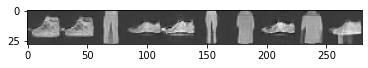

epoch: 22, d_loss: 1.088001012802124, g_loss: 1.031805396080017
epoch: 23, d_loss: 1.1002306938171387, g_loss: 1.0236049890518188
epoch: 24, d_loss: 1.1016160249710083, g_loss: 1.0221482515335083
epoch: 25, d_loss: 1.1040575504302979, g_loss: 1.0204190015792847
epoch: 26, d_loss: 1.1101001501083374, g_loss: 1.0169905424118042
epoch: 27, d_loss: 1.0993854999542236, g_loss: 1.031386375427246
epoch: 28, d_loss: 1.0792535543441772, g_loss: 1.0535292625427246
epoch: 29, d_loss: 1.091414213180542, g_loss: 1.0459840297698975
epoch: 30, d_loss: 1.1029917001724243, g_loss: 1.0369373559951782
epoch: 31, d_loss: 1.1062543392181396, g_loss: 1.034557580947876


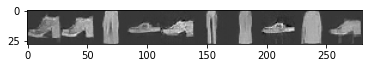

epoch: 32, d_loss: 1.1049559116363525, g_loss: 1.0367234945297241
epoch: 33, d_loss: 1.0924351215362549, g_loss: 1.0511521100997925
epoch: 34, d_loss: 1.0861750841140747, g_loss: 1.0594340562820435
epoch: 35, d_loss: 1.1138955354690552, g_loss: 1.0398629903793335
epoch: 36, d_loss: 1.100106954574585, g_loss: 1.0500407218933105
epoch: 37, d_loss: 1.0901000499725342, g_loss: 1.0620012283325195
epoch: 38, d_loss: 1.0862575769424438, g_loss: 1.065622329711914
epoch: 39, d_loss: 1.072237253189087, g_loss: 1.0818792581558228
epoch: 40, d_loss: 1.0809898376464844, g_loss: 1.072786808013916
epoch: 41, d_loss: 1.0835195779800415, g_loss: 1.071661353111267


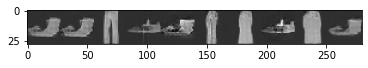

epoch: 42, d_loss: 1.085370421409607, g_loss: 1.0736621618270874
epoch: 43, d_loss: 1.1066745519638062, g_loss: 1.0586390495300293
epoch: 44, d_loss: 1.0968471765518188, g_loss: 1.0680232048034668
epoch: 45, d_loss: 1.0830302238464355, g_loss: 1.082338571548462
epoch: 46, d_loss: 1.1133930683135986, g_loss: 1.052077293395996
epoch: 47, d_loss: 1.1166366338729858, g_loss: 1.0475826263427734
epoch: 48, d_loss: 1.1028929948806763, g_loss: 1.0668681859970093
epoch: 49, d_loss: 1.1018180847167969, g_loss: 1.0641169548034668
epoch: 50, d_loss: 1.1107208728790283, g_loss: 1.055588722229004
epoch: 51, d_loss: 1.101902723312378, g_loss: 1.0698374509811401


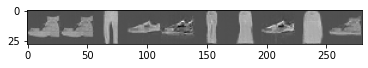

epoch: 52, d_loss: 1.1025912761688232, g_loss: 1.0650603771209717
epoch: 53, d_loss: 1.113756775856018, g_loss: 1.054691195487976
epoch: 54, d_loss: 1.117261290550232, g_loss: 1.0568640232086182
epoch: 55, d_loss: 1.1129568815231323, g_loss: 1.0588178634643555
epoch: 56, d_loss: 1.1157503128051758, g_loss: 1.0546976327896118
epoch: 57, d_loss: 1.1134204864501953, g_loss: 1.057730793952942
epoch: 58, d_loss: 1.113899827003479, g_loss: 1.059738039970398
epoch: 59, d_loss: 1.0879156589508057, g_loss: 1.0878280401229858
epoch: 60, d_loss: 1.11810302734375, g_loss: 1.0594197511672974
epoch: 61, d_loss: 1.1040959358215332, g_loss: 1.0704771280288696


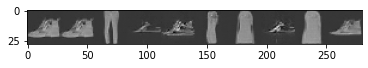

epoch: 62, d_loss: 1.114190936088562, g_loss: 1.0648407936096191
epoch: 63, d_loss: 1.0892460346221924, g_loss: 1.084799885749817
epoch: 64, d_loss: 1.0971190929412842, g_loss: 1.0815619230270386
epoch: 65, d_loss: 1.110532283782959, g_loss: 1.0690449476242065
epoch: 66, d_loss: 1.1108845472335815, g_loss: 1.0698628425598145
epoch: 67, d_loss: 1.100523591041565, g_loss: 1.0789337158203125
epoch: 68, d_loss: 1.1029599905014038, g_loss: 1.0780003070831299
epoch: 69, d_loss: 1.1021403074264526, g_loss: 1.077732801437378
epoch: 70, d_loss: 1.093614935874939, g_loss: 1.0838046073913574
epoch: 71, d_loss: 1.087659239768982, g_loss: 1.0932151079177856


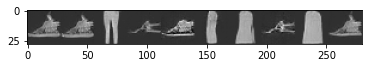

epoch: 72, d_loss: 1.085526704788208, g_loss: 1.0965200662612915
epoch: 73, d_loss: 1.0990715026855469, g_loss: 1.0869675874710083
epoch: 74, d_loss: 1.1010831594467163, g_loss: 1.0880268812179565
epoch: 75, d_loss: 1.1059226989746094, g_loss: 1.0840318202972412
epoch: 76, d_loss: 1.0854774713516235, g_loss: 1.0979689359664917


In [ ]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()